### Importing dependencies 

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import glob
import matplotlib.pyplot as plt 

In [2]:
train_path  = "/kaggle/input/chest-x-ray/train_test_split/train_test_split/train"
valid_path  = "/kaggle/input/chest-x-ray/train_test_split/train_test_split/validation"
test_path   = "/kaggle/input/chest-x-ray/train_test_split/train_test_split/test"

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, MaxPool2D, Conv2D
import keras

### Preprocessing for feeding input images to the CNN

In [4]:
train_data_gen = ImageDataGenerator(preprocessing_function= vgg16.preprocess_input , zoom_range= 0.2, horizontal_flip= True, shear_range= 0.2 , rescale= 1./255)
train = train_data_gen.flow_from_directory(directory= train_path , target_size=(224,224))

Found 7800 images belonging to 2 classes.


In [5]:
validation_data_gen = ImageDataGenerator(preprocessing_function= vgg16.preprocess_input , rescale= 1./255 )
valid = validation_data_gen.flow_from_directory(directory= valid_path , target_size=(224,224))

Found 1008 images belonging to 2 classes.


In [6]:
test_data_gen = ImageDataGenerator(preprocessing_function= vgg16.preprocess_input, rescale= 1./255 )
test = train_data_gen.flow_from_directory(directory= test_path , target_size=(224,224), shuffle= False)

Found 800 images belonging to 2 classes.


In [7]:
class_type = {0:'Covid',  1 : 'Normal'}

In [8]:
t_img , label = train.next()

In [9]:
def plotImages(img_arr, label):
    for im, l in zip(img_arr,label) :
        plt.figure(figsize= (5,5))
        plt.imshow(im, cmap = 'gray')
        plt.title(im.shape)
        plt.axis = False
        plt.show()

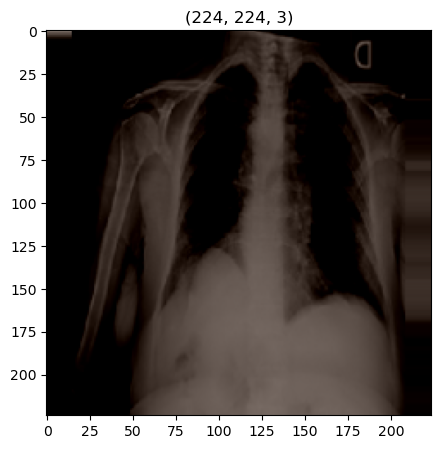

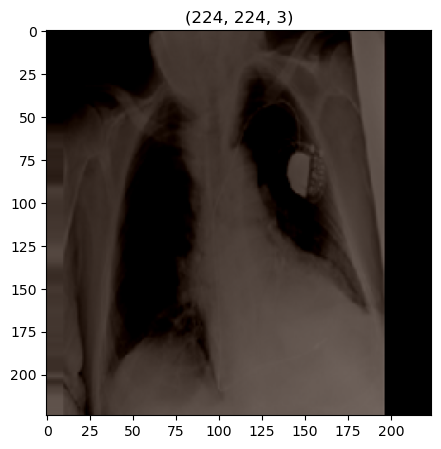

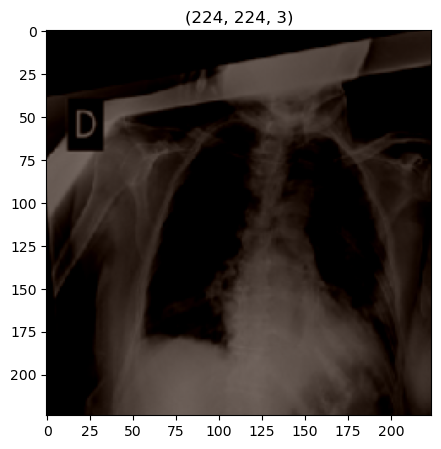

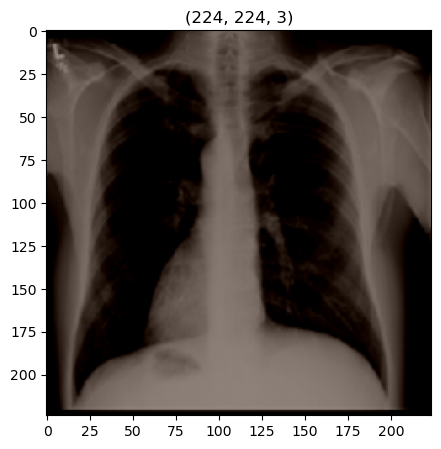

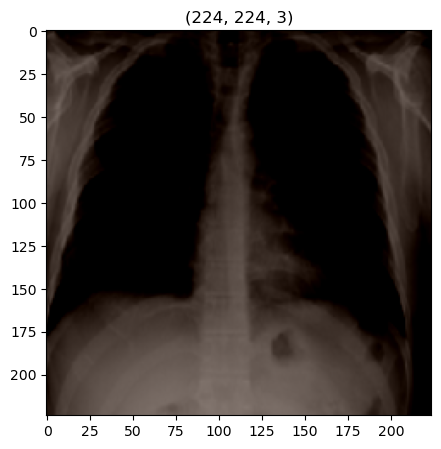

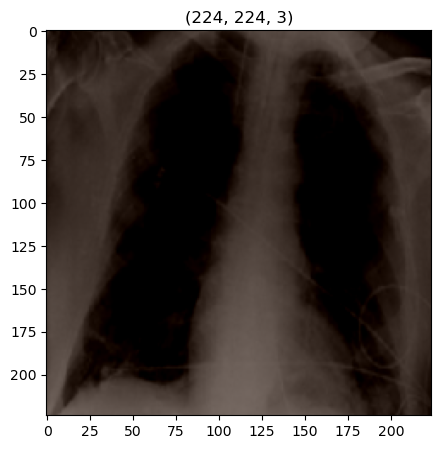

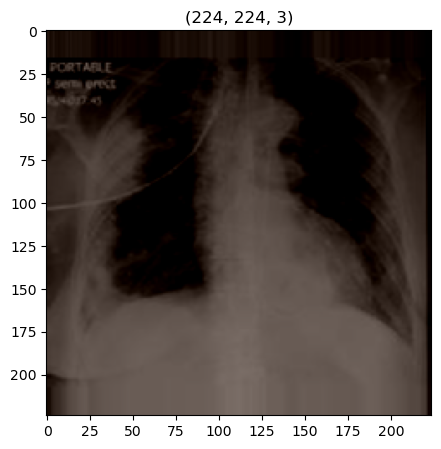

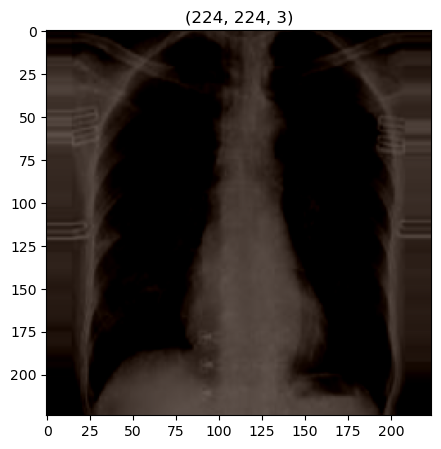

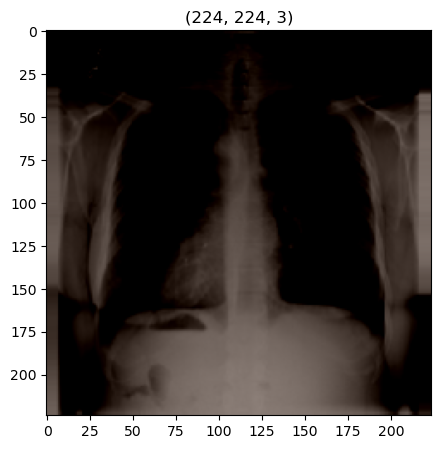

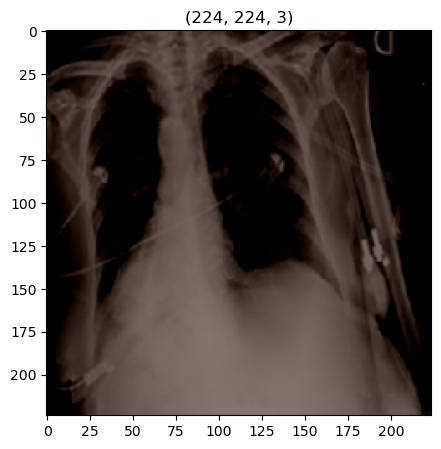

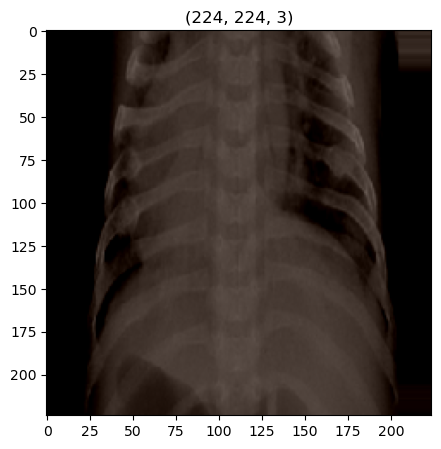

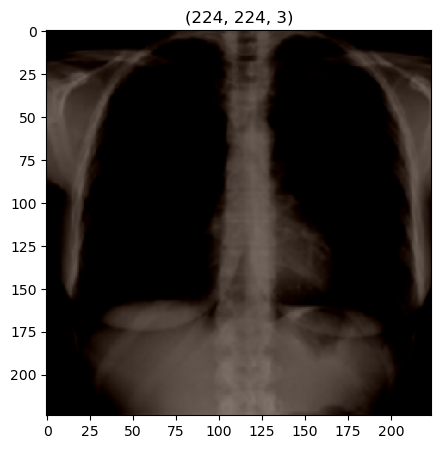

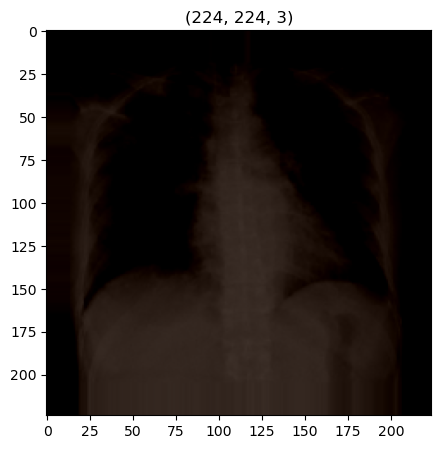

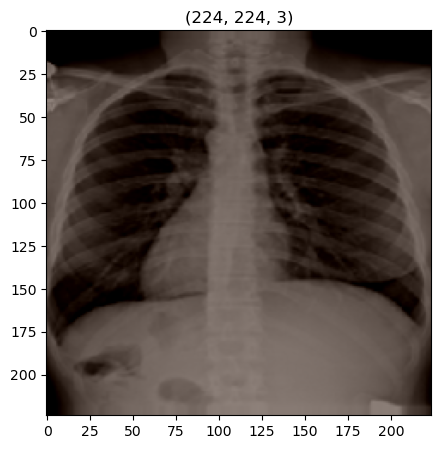

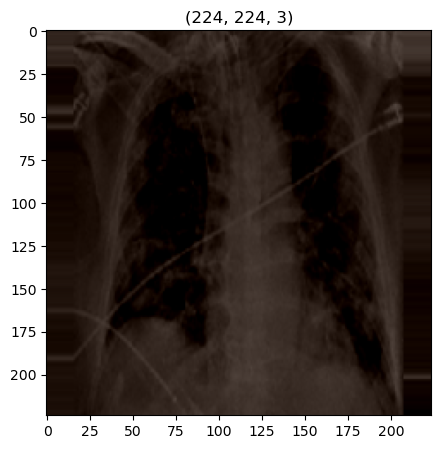

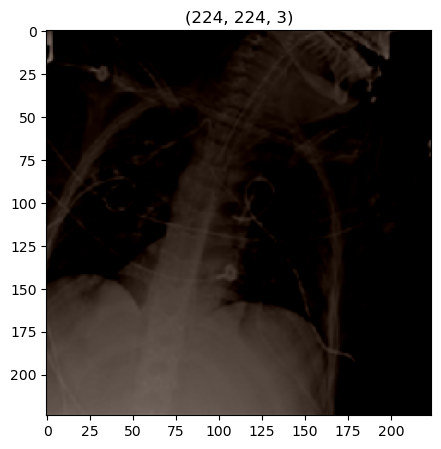

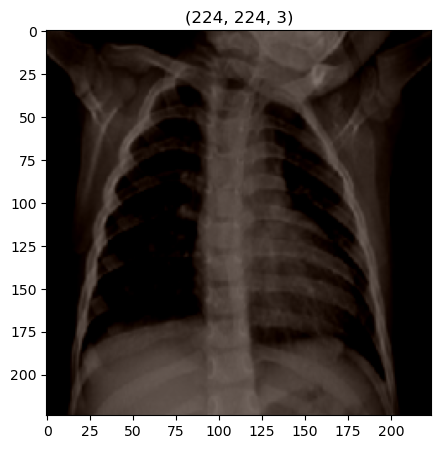

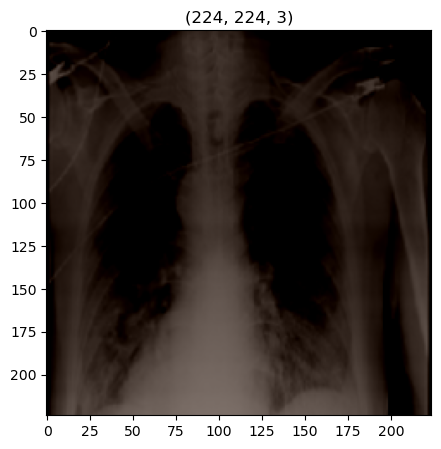

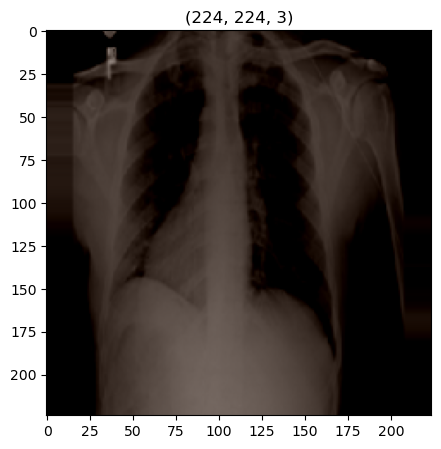

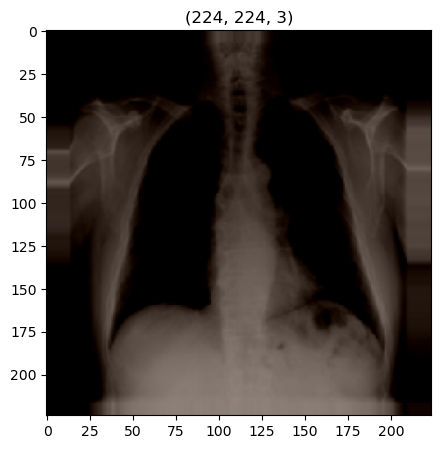

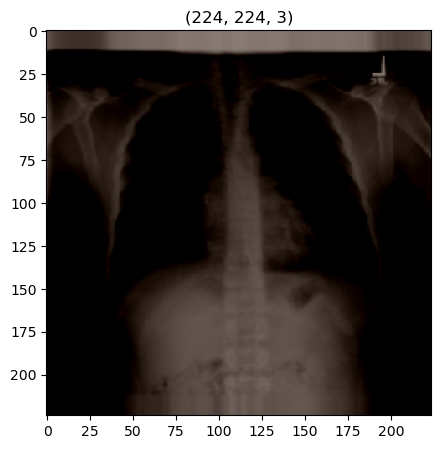

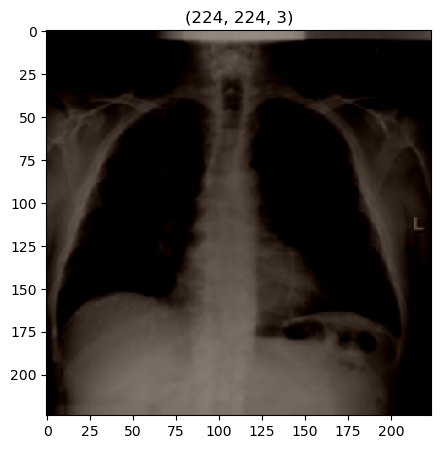

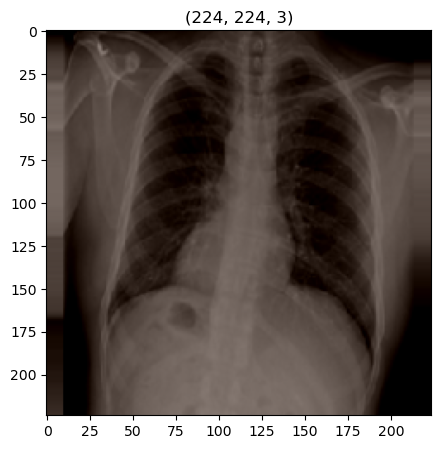

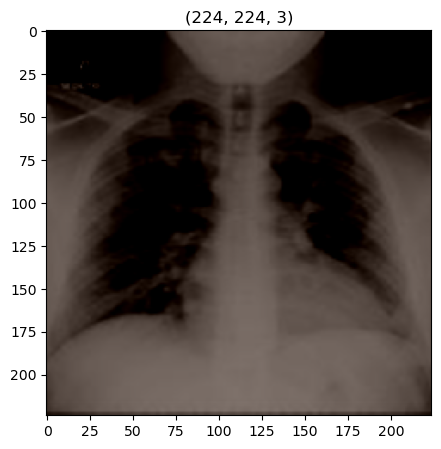

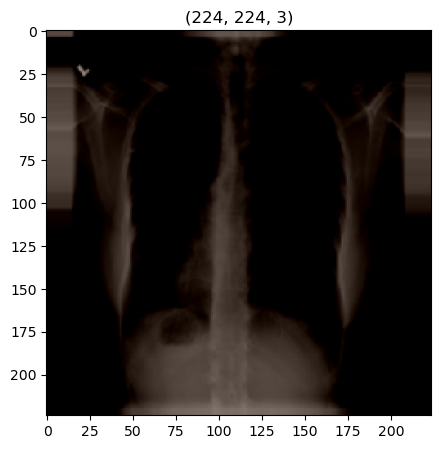

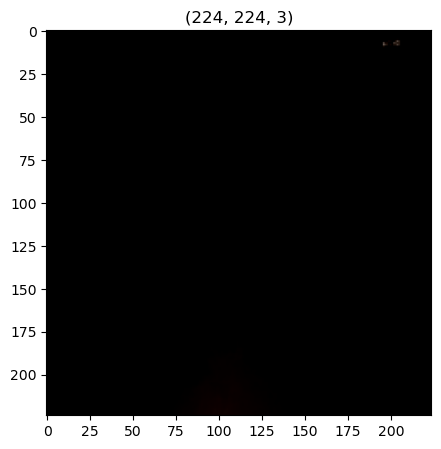

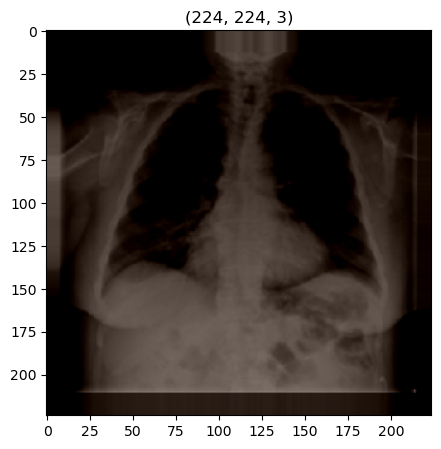

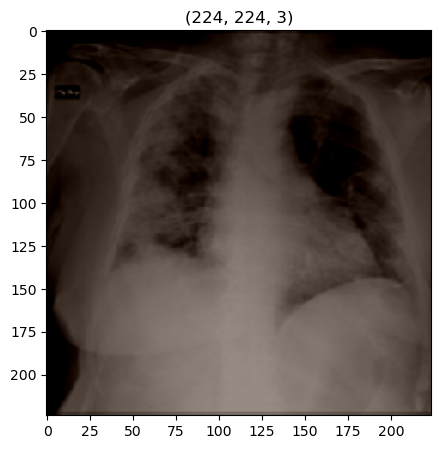

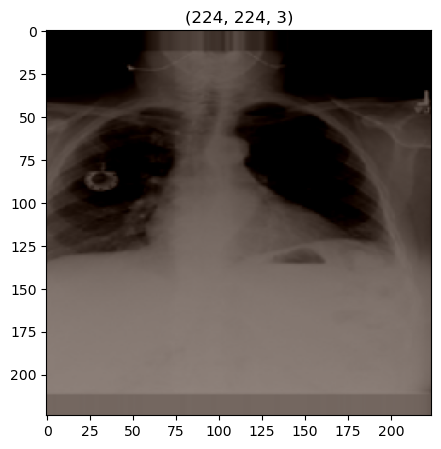

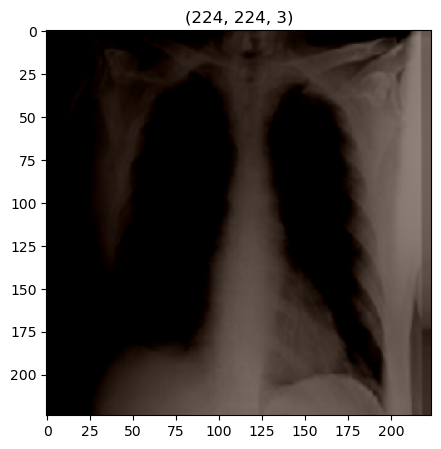

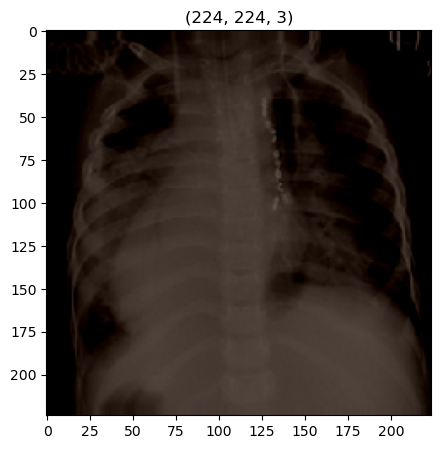

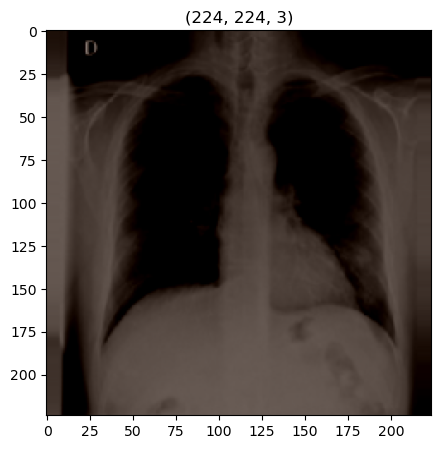

In [10]:
plotImages(t_img, label)

### Designing the CNN model

In [11]:
vgg = VGG16( input_shape=(224,224,3), include_top= False)

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
for layer in vgg.layers:        
    layer.trainable = False

In [13]:
x = Flatten()(vgg.output)
x = Dense(units=2 , activation='sigmoid', name = 'predictions' )(x)

model = Model(vgg.input, x)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

### Training the model

In [24]:
hist = model.fit(train, steps_per_epoch= 10, epochs= 30, validation_data= valid , validation_steps= 32, callbacks=[es,mc])

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.4176 - accuracy: 0.8062
Epoch 1: val_accuracy improved from 0.82440 to 0.83036, saving model to bestmodel.h5
10/10 [==============================] - 13s 1s/step - loss: 0.4176 - accuracy: 0.8062 - val_loss: 0.3919 - val_accuracy: 0.8304
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8406
Epoch 2: val_accuracy improved from 0.83036 to 0.85516, saving model to bestmodel.h5
10/10 [==============================] - 12s 1s/step - loss: 0.3634 - accuracy: 0.8406 - val_loss: 0.3518 - val_accuracy: 0.8552
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8531
Epoch 3: val_accuracy did not improve from 0.85516
10/10 [==============================] - 12s 1s/step - loss: 0.3270 - accuracy: 0.8531 - val_loss: 0.4043 - val_accuracy: 0.8284
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.8531
Epoch 4: val_acc

### Loading the model and evaluation 

In [25]:
from keras.models import load_model
model = load_model("bestmodel.h5")

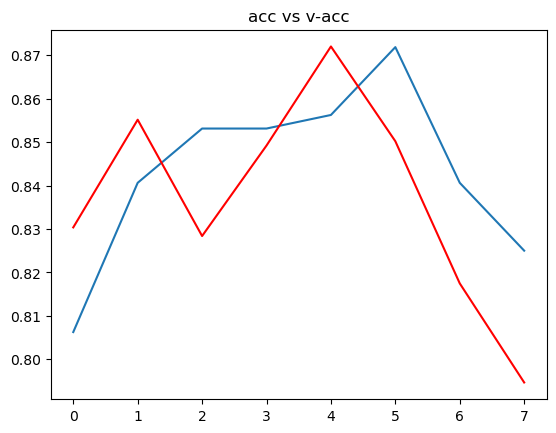

In [26]:
h = hist.history
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

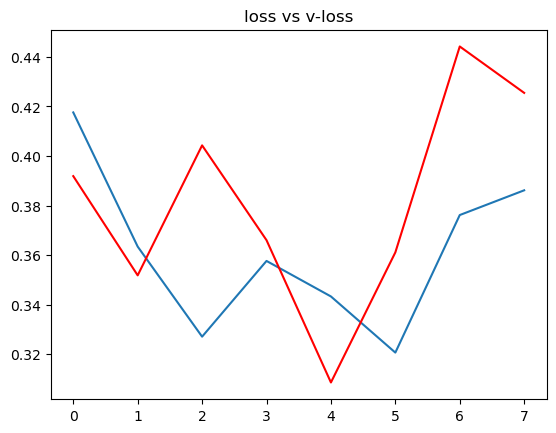

In [27]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [28]:
acc = model.evaluate(test)[1] 

print(f"The accuracy of your model is = {acc} %")

25/25 [==============================] - 13s 512ms/step - loss: 0.2789 - accuracy: 0.8863
The accuracy of your model is = 0.8862500190734863 %


We get an accuracy of 88.62%

In [29]:
def get_img_array(img_path):
    path = img_path
    img = keras.utils.load_img(path, target_size=(224,224,3))
    img = keras.utils.img_to_array(img)/255
    img = np.expand_dims(img , axis= 0 )
    return img

1/1 [==============================] - 0s 168ms/step
The given X-Ray image is of type = Covid

1/1 [==============================] - 0s 29ms/step
The chances of image being Covid is : 74.75252747535706 percent

1/1 [==============================] - 0s 28ms/step
The chances of image being Normal is : 38.533779978752136 percent


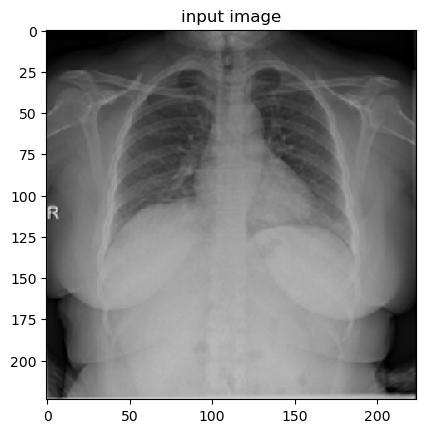

In [30]:
path = "/kaggle/input/chest-x-ray/Output/Output/COVID-3325.png"      
img = get_img_array(path)

res = class_type[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")


plt.imshow(img[0], cmap = "gray")
plt.title("input image")
plt.show()

Thus, the model gives correct classification for this new X-ray image